# Bagging and Random Forest Models

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a final better prediction. 

In this lab you will work with a widely used ensemble method known as **bootstrap aggregating** or simply **bagging**. Bagging follows a simple procedure:
1. N learners (machine learning models) are defined. 
2. N subsamples of the training data are created by **Bernoulli sampling with replacement**.
3. The N learners are trained on the subsamples of the training data.
4. The ensemble is scored by averaging, or taking a majority vote, of the predictions from the N learners.

**Classification and regression tree models** are most typically used with bagging methods. The most common such algorithm is know as the **random forest**. The random forest method is highly scalable and generally produces good results, even for complex problems. 

Classification and regression trees tend to be robust to noise or outliers in the training data. This is true for the random forest algorithm as well. 

## Example: Iris dataset

As a first example you will use random forest to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [17]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(randomForest)
library(MLmetrics)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

The code in the cell below displays the head of the data frame and plots all pairwise combinations of the features with the species of the iris flower in colors. Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


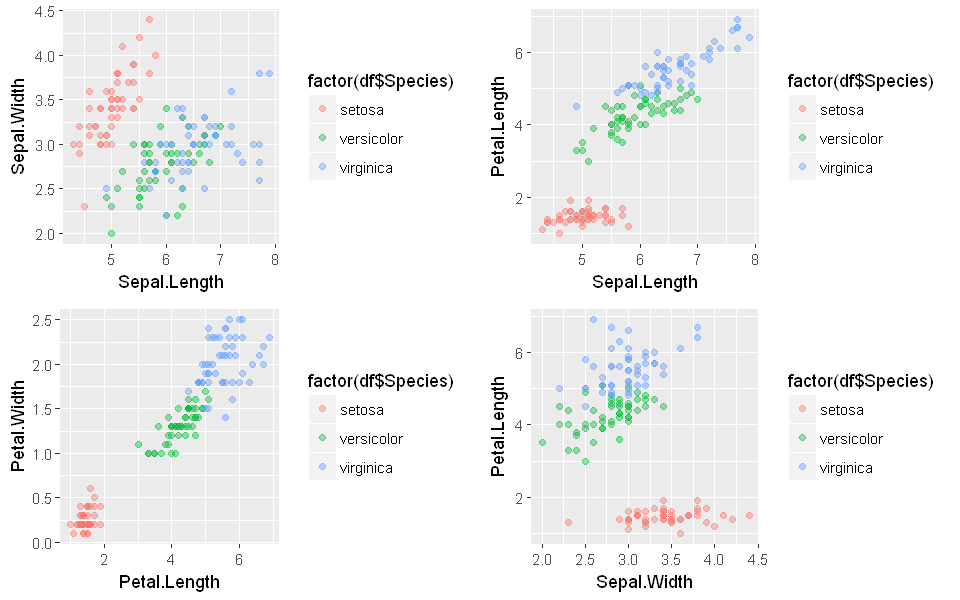

In [18]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris)

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [19]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [20]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit a random forest model. The code in the cell below defines random forest model with 5 trees using the `randomForest` function from the R randomForest package, and then fits the model. Execute this code.

In [21]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 5)

Next, the code in the cell below uses the `predict` method is used to compute the class score from the scaled features. Execute this code. 

In [22]:
test$scores = predict(rf_mod, newdata = test)
head(iris, 20)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


It is time to evaluate the model results. Keep in mind that the problem has been made difficult deliberately, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [23]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         31         2
  virginica       0          3        30

Accuracy =  0.949 
 
          setosa versicolor virginica
Precision      1      0.939     0.909
Recall         1      0.912     0.938
F1             1      0.925     0.923


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.
|
To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

Is it possible that a random forest model with more trees would separate these cases better? The code in the cell below uses a model with 40 trees (estimators). This model is fit with the training data and displays the evaluation of the model. 

Execute this code and answer **Question 1** on the course page.

In [24]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         31         2
  virginica       0          3        30

Accuracy =  0.949 
 
          setosa versicolor virginica
Precision      1      0.939     0.909
Recall         1      0.912     0.938
F1             1      0.925     0.923


These results are identical to the model with 5 trees. 

Like most tree-based models, random forest models have a nice property that **feature importance** is computed during model training. Feature importance can be used as a feature selection method. The `varImp` function from the Caret package performs the calculation.  

Execute the code in the cell below to display a plot of the feature importance.

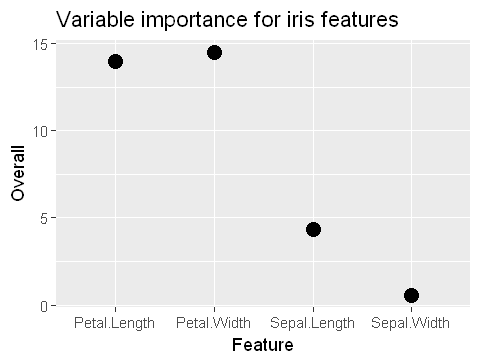

In [25]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(rf_mod)
imp[,'Feature'] = row.names(imp)
ggplot(imp, aes(x = Feature, y = Overall)) + geom_point(size = 4) +
       ggtitle('Variable importance for iris features')

Examine the plot displayed above. Notice that the Speal_Lenght and Sepal_Width have rather low importance. 

Should these features be dropped from the model? To find out, you will create a model with a reduced feature set and compare the results. As a first step, execute the code in the cell below to create training and test datasets using the reduced features.

In [26]:
set.seed(1115)
rf_mod = randomForest(Species ~ Petal.Length + Petal.Width, data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         32         1
  virginica       0          3        30

Accuracy =  0.96 
 
          setosa versicolor virginica
Precision      1      0.970     0.909
Recall         1      0.914     0.968
F1             1      0.941     0.937


Once you have executed the code, answer **Question 2** on the course page.

These results are a bit better which may indicate the original model was overfit. Given that a simpler model is more likely to generalize, this model is preferred. 

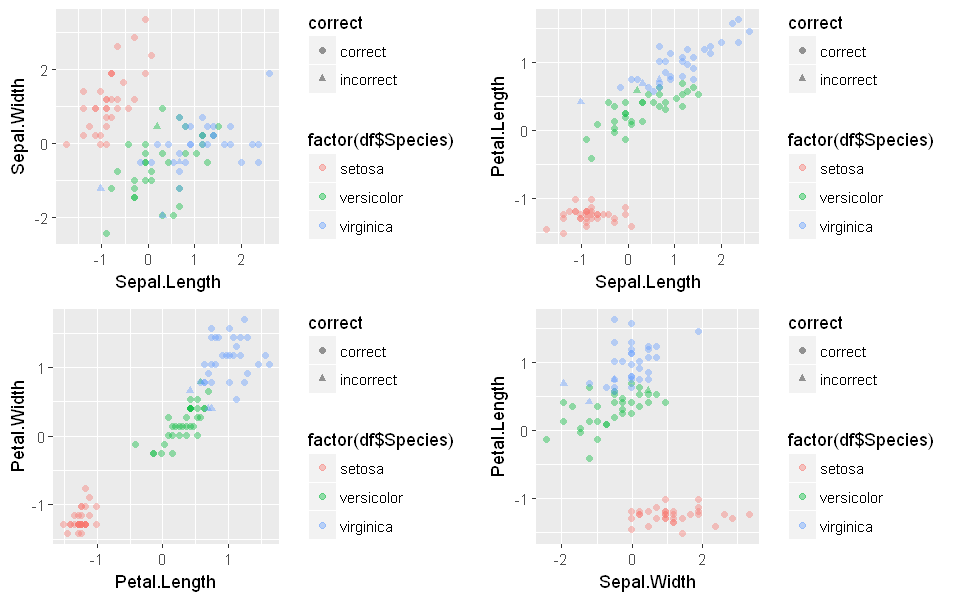

In [27]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

## Another example


Now, you will try a more complex example using the credit scoring data. You will use the prepared data which has been prepared by removing duplicate cases. Some columns which are know not to be predictive are removed. Execute the code in the cell below to load the dataset for the example. 

In [28]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 999  16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [29]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

In [30]:
credit$bad_credit <- ifelse(credit$bad_credit == 0, 'good', 'bad')
credit$bad_credit <- factor(credit$bad_credit, levels = c("bad", "good"))
credit$bad_credit[1:5]

[1] bad  good good bad  good
Levels: bad good

In the results above you can see the new coding of the label column along with the levels, {'bad', 'good'}. 

As the inner loop of a nested cross validation, the code in the cell below uses the capability of the R Caret package to estimate the best hyperparameters using 5 fold cross validation. This first cross validation is performed using ROC as the metric. There are a few points to note here:
1. A Caret `trainControl` object is used to define the 5 fold cross validation. The `twoClassSummary` function is specified, making ROC the metric for hyperparameter optimization. 
2. The model is trained using all features as can be seen from the model formula in the Caret `train` function. 
3. `ROC` is specified as a `metric` in the call to `train`. 
4. Weights are specified to help with the class imbalance and the cost imbalance of misclassification of bad credit customers. 
5. The `train` function uses a `tuneGrid` argument to define the hyperparameters to search. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [31]:
weights = ifelse(credit$bad_credit == 'bad', 0.9, 0.1)

fitControl <- trainControl(method = "cv",
                           number = 5,
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)
paramGrid <- expand.grid(mtry = c(5, 10, 15))

set.seed(1234)
rf_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "rf", # Random forest model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights, 
                          metric="ROC")
print(rf_fit_inside_tw)

Random Forest 

999 samples
 15 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   5    0.7774743  0.3966667  0.9156218
  10    0.7753214  0.4300000  0.9013155
  15    0.7745194  0.4433333  0.9041727

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


The grid of hyperpameters searched by the Caret package is only `mtry`. The printed tables shows the values of the metrics as a function of the parameters in the search grid. Sens is short for sensitivity which is the same as global recall and Spec is specificity which is the true negative rate $= \frac{TN}{TN + FP}$

The hyperparameter optimization can also be performed using Recall as a metric. The code in the cell below uses the `prSummary` function for the `summaryFunction` argument for `trainControl` and sets the `metric` as `Recall`. Execute this call and examine the results.    

In [32]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = prSummary)
paramGrid <- expand.grid(mtry = c(5, 15, 25))

set.seed(1234)
rf_fit_inside_pr <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "rf", # Random forest model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights, 
                          metric="Recall")
print(rf_fit_inside_pr)

Random Forest 

999 samples
 15 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Resampling results across tuning parameters:

  mtry  AUC        Precision  Recall     F        
   5    0.6137526  0.6775870  0.3966667  0.4976127
  15    0.6088773  0.6452938  0.4433333  0.5251996
  25    0.6003193  0.6322882  0.4600000  0.5322732

Recall was used to select the optimal model using the largest value.
The final value used for the model was mtry = 25.


Given the problem, these results seem reasonable. 

The question now is, given the optimal hyperparameters, which features are the most important? The code in the cell below computes and displays feature importance using the Caret `varImp` function. Execute this code and examine the results. 

rf variable importance

  only 20 most important variables shown (out of 27)

                                                      Overall
loan_amount                                           100.000
age_yrs                                                65.507
loan_duration_mo                                       56.404
checking_account_statusnone                            48.526
time_in_residence                                      20.374
payment_pcnt_income                                    17.813
savings_account_balanceunknown/none                     9.064
other_credit_outstandingnone                            9.001
number_loans                                            6.112
telephoneyes                                            6.068
credit_historycritical account - other non-bank loans   6.052
propertyreal estate                                     5.975
time_employed_yrsunemployed                             5.830
checking_account_status0 - 200 DM                     

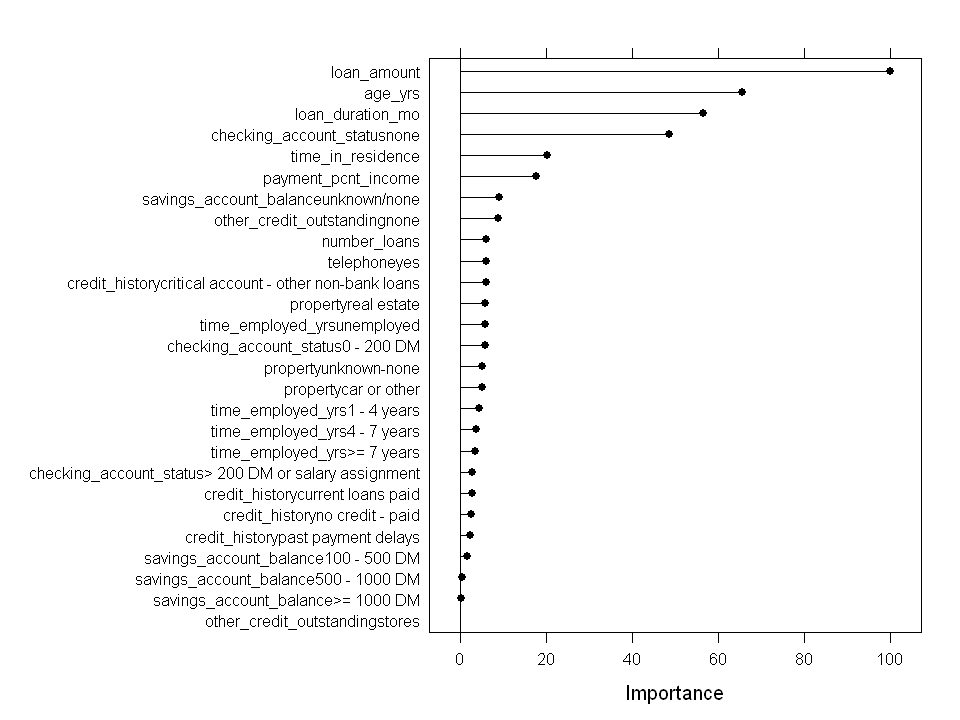

In [39]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(rf_fit_inside_pr)
print(var_imp)
plot(var_imp)

In is clear that some of the features are not important to model performance. Execute the code in the cell below to prune the feature set:

In [34]:
credit_reduced = credit[,c('loan_amount', 'age_yrs', 'loan_duration_mo', 'checking_account_status', 'time_in_residence',
                          'payment_pcnt_income', 'savings_account_balance', 'other_credit_outstanding', 
                          'credit_history', 'time_employed_yrs', 'property', 'number_loans', 'telephone',
                          'bad_credit')]

You will now run the inside loop of the CV to test the reduced feature set. Execute the code in the cell below to perform the cross validation grid search using the reduced feature set: 

In [35]:
set.seed(3344)
rf_fit_inside_pr <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "rf", # Random forest model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights, 
                          metric="Recall")
print(rf_fit_inside_pr)

Random Forest 

999 samples
 13 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 799, 800, 799, 799, 799 
Resampling results across tuning parameters:

  mtry  AUC        Precision  Recall     F        
   5    0.6059696  0.6591725  0.4166667  0.5099668
  15    0.5973096  0.6189748  0.4266667  0.5047690
  25    0.5887602  0.5984532  0.4400000  0.5068602

Recall was used to select the optimal model using the largest value.
The final value used for the model was mtry = 25.


The results of the cross validation grid search with the reduced feature are slightly lower than before. However, this difference is unlikely to be significant. The optimal value of `mtry` is still 25. Evidentially, pruning these features was the correct step. This process can be continued, but will not be in this lab in the interest of reducing length. 

To verify that the model will generalize well it is time to perform the outside CV loop. The code in the cell below defines a parameter grid with just the optimal hyperparameter value. The CV then repeatedly fits the model with this single hyperparameter. Execute this code and examine the result.

In [36]:
## Set the hyperparameter grid to the optimal values from the inside loop
paramGrid <- expand.grid(mtry = c(rf_fit_inside_pr$finalModel$mtry))

set.seed(5678)
rf_fit_outside_pr <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "rf", # Random forest model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights,
                          metric = "Recall")

print_metrics = function(mod){
    means = c(apply(mod$resample[,1:4], 2, mean), mtry = mod$resample[1,5], Resample = 'Mean')
    stds = c(apply(mod$resample[,1:4], 2, sd), mtry = mod$resample[1,5], Resample = 'STD')
    out = rbind(mod$resample, means, stds)
    out[,1:4] = lapply(out[,1:4], function(x) round(as.numeric(x), 3))
    out
}
print_metrics(rf_fit_outside_pr)

AUC,Precision,Recall,F,mtry,Resample
0.628,0.667,0.533,0.593,25,Fold1
0.644,0.680,0.567,0.618,25,Fold2
0.618,0.558,0.400,0.466,25,Fold3
0.568,0.579,0.367,0.449,25,Fold4
0.540,0.571,0.467,0.514,25,Fold5
0.600,0.611,0.467,0.528,25,Mean
0.044,0.058,0.085,0.075,25,STD


Examine these results. Notice that the standard deviation of the mean of the AUC are nearly an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

***
**Note:** The predict method can be used with this optimal model to classify unknown cases.
***

## Summary

In this lab you have accomplished the following:
1. Used a random forest model to classify the cases of the iris data. A model with more trees had marginally lower error rates, but likely not significantly different.
2. Used 5 fold to find estimated optimal hyperparameters for a random forest model to classify credit risk cases. This process is the inner loop of a nested cross validation process. 
3. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
4. Performed the outer loop of nested cross validation with a 5 fold CV to confirm that the model will likely generalize well. 